In [1]:
# PRE- INSTALLATIONS

In [2]:
# ✅ Install required libraries (if not installed)
!pip install qiskit qiskit-machine-learning torch torchvision matplotlib scikit-learn numpy pillow

In [3]:
# FULL CODE IMPLEMENTATION

<ipython-input-4-aa97aedc2413>:85: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


Epoch 1/6, Train Loss: 0.6686, Train Acc: 75.18%, Test Loss: 0.4858, Test Acc: 80.24%
Epoch 2/6, Train Loss: 0.2961, Train Acc: 88.53%, Test Loss: 0.3459, Test Acc: 86.42%
Epoch 3/6, Train Loss: 0.1572, Train Acc: 94.12%, Test Loss: 0.1923, Test Acc: 93.14%
Epoch 4/6, Train Loss: 0.0704, Train Acc: 97.46%, Test Loss: 0.1326, Test Acc: 94.81%
Epoch 5/6, Train Loss: 0.0386, Train Acc: 98.72%, Test Loss: 0.2304, Test Acc: 92.98%
Epoch 6/6, Train Loss: 0.0226, Train Acc: 99.25%, Test Loss: 0.1986, Test Acc: 94.20%


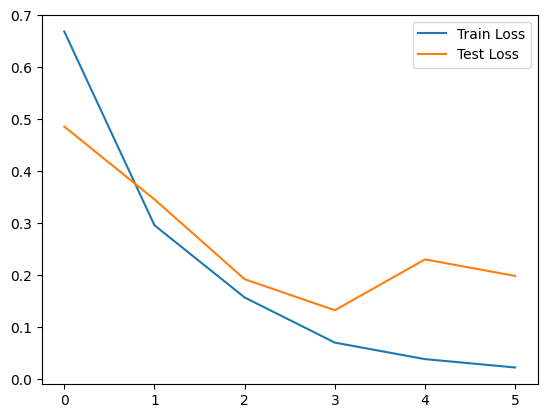

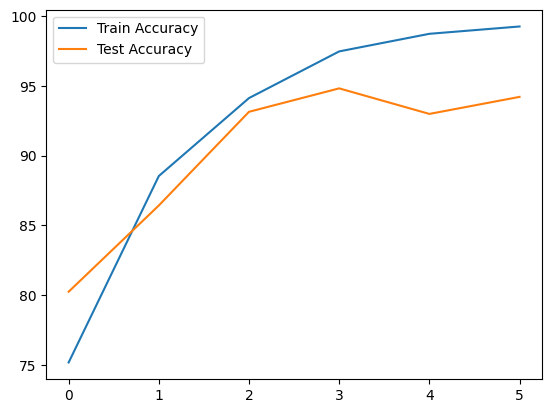

In [4]:
# ✅ Install required libraries (if not installed)
!pip install qiskit qiskit-machine-learning torch torchvision matplotlib scikit-learn numpy pillow

# ✅ Import Libraries
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn import metrics
from PIL import Image
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# ✅ Set dataset paths
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"
train_path = os.path.join(dataset_path, "Training")
test_path = os.path.join(dataset_path, "Testing")

# ✅ Class mapping
class_labels = {"glioma": 0, "meningioma": 1, "notumor": 2, "pituitary": 3}

# ✅ Function to Load Images
def load_images_from_folder(folder, label, target_size=(128, 128)):
    data, labels = [], []
    for img_path in glob.glob(os.path.join(folder, "*.jpg")):  
        try:
            img = Image.open(img_path).convert("RGB").resize(target_size)
            data.append(np.array(img))
            labels.append(label)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return np.array(data), np.array(labels)

# ✅ Load Training & Testing Data
train_data, train_labels = [], []
test_data, test_labels = [], []

for category, label in class_labels.items():
    train_images, train_labels_list = load_images_from_folder(os.path.join(train_path, category), label)
    test_images, test_labels_list = load_images_from_folder(os.path.join(test_path, category), label)

    train_data.append(train_images)
    train_labels.append(train_labels_list)
    test_data.append(test_images)
    test_labels.append(test_labels_list)

# ✅ Combine all categories
X_train = np.concatenate(train_data, axis=0) / 255.0
y_train = np.eye(4)[np.concatenate(train_labels, axis=0)]  
X_test = np.concatenate(test_data, axis=0) / 255.0
y_test = np.eye(4)[np.concatenate(test_labels, axis=0)]  

# ✅ Move Model and Data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# ✅ Define DataLoader
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

# ✅ Create Quantum Neural Network (QNN) using EstimatorQNN
def create_qnn():
    num_qubits = 3
    feature_map = ZZFeatureMap(feature_dimension=num_qubits)
    ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2)

    qc = QuantumCircuit(num_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True  
    )
    
    return qnn

# ✅ Updated Quantum-CNN Model
class QuantumCNN(nn.Module):
    def __init__(self, quantum_layer):
        super(QuantumCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.quantum_layer = quantum_layer
        
        self.fc1 = nn.Linear(246017, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)  

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
    
        x = x.reshape(x.size(0), -1)  
    
        quantum_input = torch.rand(x.size(0), 3).to(x.device)  
        quantum_out = self.quantum_layer(quantum_input)
        x = torch.cat((x, quantum_out), dim=1)
    
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
    
        return x

# ✅ Initialize Quantum-CNN Model
qnn = create_qnn()
quantum_layer = TorchConnector(qnn)
quantum_model = QuantumCNN(quantum_layer).to(device)

# ✅ Store training and testing metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# ✅ Define Training Function
def fit_quantum_model(model, train_loader, test_loader, epochs=6, save_path="quantum_cnn_model.pth"):
    global train_losses, test_losses, train_accuracies, test_accuracies
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, torch.argmax(y_batch, dim=1))
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            correct_train += (torch.argmax(outputs, dim=1) == torch.argmax(y_batch, dim=1)).sum().item()
            total_train += y_batch.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train * 100)

        # ✅ Evaluate on Test Data
        model.eval()
        test_loss, correct_test, total_test = 0, 0, 0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, torch.argmax(y_batch, dim=1))
                
                test_loss += loss.item()
                correct_test += (torch.argmax(outputs, dim=1) == torch.argmax(y_batch, dim=1)).sum().item()
                total_test += y_batch.size(0)

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(correct_test / total_test * 100)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
              f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")

    torch.save(model.state_dict(), save_path)

# ✅ Train Model
fit_quantum_model(quantum_model, train_loader, test_loader, epochs=6)

# ✅ Plot Graphs
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.legend()
plt.show()


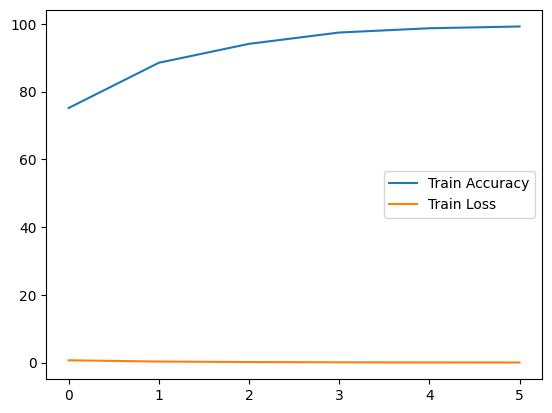

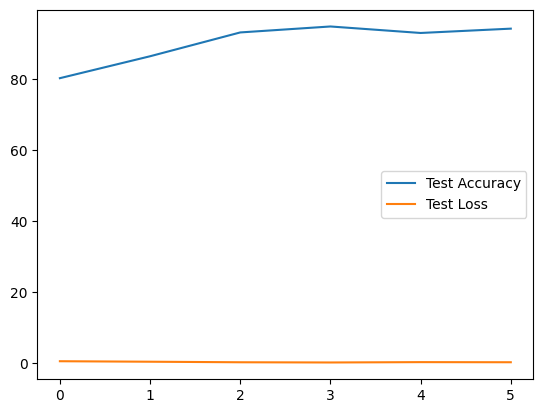

In [21]:
# ✅ Plot Graphs
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(train_losses, label="Train Loss")
plt.legend()
plt.show()

plt.plot(test_accuracies, label="Test Accuracy")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.show()

In [5]:
# CLASSIFICATION REPORT

In [6]:
from sklearn.metrics import classification_report

# ✅ Evaluate Model on Test Data
quantum_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = quantum_model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = torch.argmax(y_batch, dim=1).cpu().numpy()
        
        y_pred.extend(preds)
        y_true.extend(labels)

# ✅ Generate Classification Report
class_names = ["Glioma", "Meningioma", "No Tumor", "Pituitary"]
report = classification_report(y_true, y_pred, target_names=class_names)

# ✅ Print the Report
print("🔹 Classification Report:")
print(report)


🔹 Classification Report:
              precision    recall  f1-score   support

      Glioma       0.97      0.84      0.90       300
  Meningioma       0.83      0.96      0.89       306
    No Tumor       0.99      0.99      0.99       405
   Pituitary       1.00      0.97      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.94      0.94      1311



In [7]:
#DRIVERS CODE

In [18]:
import torch
import torchvision.transforms as transforms
import numpy as np
from PIL import Image

# ✅ Define class labels (Matching Dataset Structure)
class_labels = {0: "Glioma", 1: "Meningioma", 2: "No Tumor", 3: "Pituitary"}

# ✅ Load the trained model
def load_model(model_path, device):
    qnn = create_qnn()  # Ensure create_qnn() function is defined
    quantum_layer = TorchConnector(qnn)
    
    model = QuantumCNN(quantum_layer).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    print(f"✅ Model loaded successfully from {model_path}")
    return model

# ✅ Preprocess Image Function (Ensures Correct Format)
def preprocess_image(image_path, target_size=(128, 128)):
    try:
        image = Image.open(image_path).convert("RGB").resize(target_size)
        image = np.array(image) / 255.0  # ✅ Normalize to match training data
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # Convert to PyTorch format
        return image
    except Exception as e:
        print(f"❌ Error loading image: {e}")
        return None

# ✅ Predict Tumor Class
def predict_tumor(image_path, model, device):
    image_tensor = preprocess_image(image_path).to(device)
    
    if image_tensor is None:
        return "Invalid Image"

    with torch.no_grad():
        outputs = model(image_tensor)
        predicted_class = torch.argmax(outputs, dim=1).item()
    
    return class_labels[predicted_class]

# ✅ Main Function to Run Prediction
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_path = "quantum_cnn_model.pth"
    
    # ✅ Load Model
    model = load_model(model_path, device)
    
    # ✅ Take Image Path as Input
    image_path = input("🔹 Enter the path of the MRI image: ").strip()
    
    # ✅ Predict Tumor Type
    prediction = predict_tumor(image_path, model, device)
    
    print(f"\n🔹 **Predicted Tumor Type:** {prediction}")


<ipython-input-4-aa97aedc2413>:85: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
<ipython-input-18-fb26fc5db16e>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting

✅ Model loaded successfully from quantum_cnn_model.pth


🔹 Enter the path of the MRI image:  /kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0000.jpg



🔹 **Predicted Tumor Type:** Meningioma


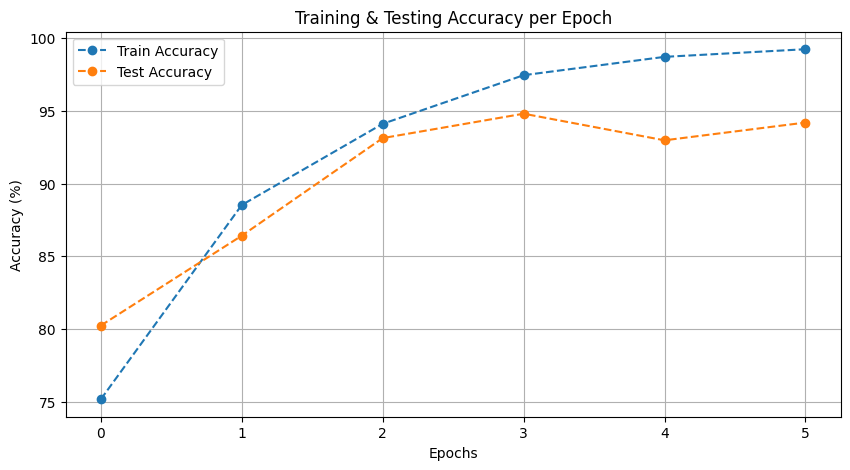

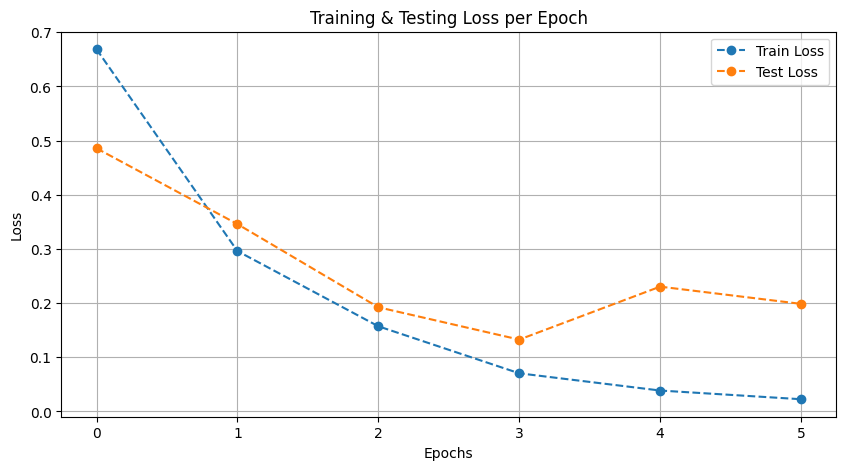


🔹 Classification Report:

              precision    recall  f1-score   support

      Glioma       0.97      0.84      0.90       300
  Meningioma       0.83      0.96      0.89       306
    No Tumor       0.99      0.99      0.99       405
   Pituitary       1.00      0.97      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.94      0.94      1311



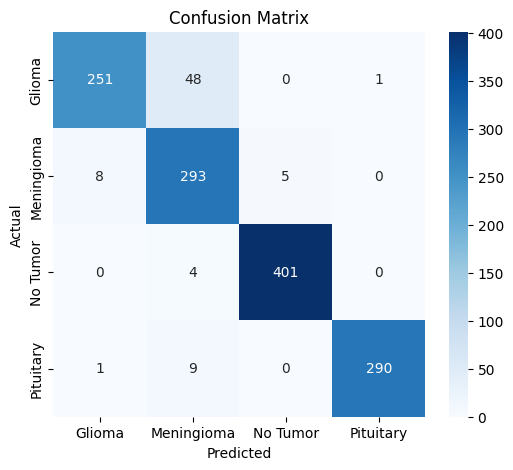

<Figure size 800x500 with 0 Axes>

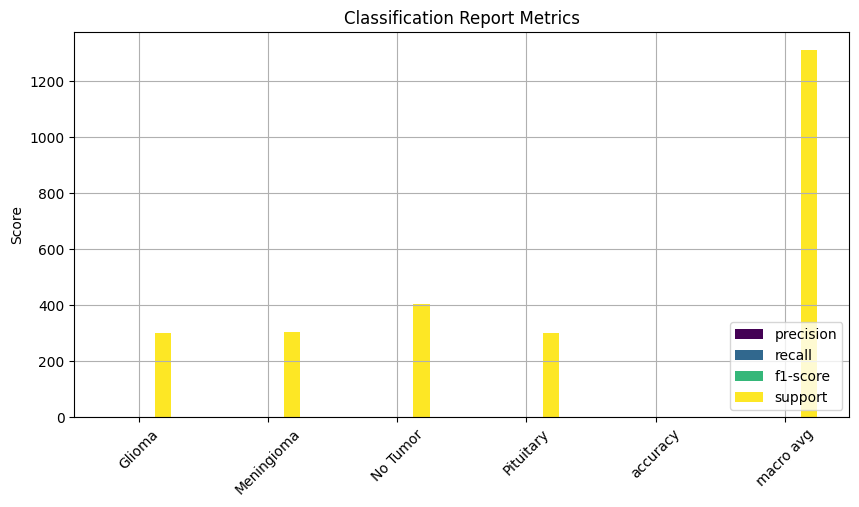

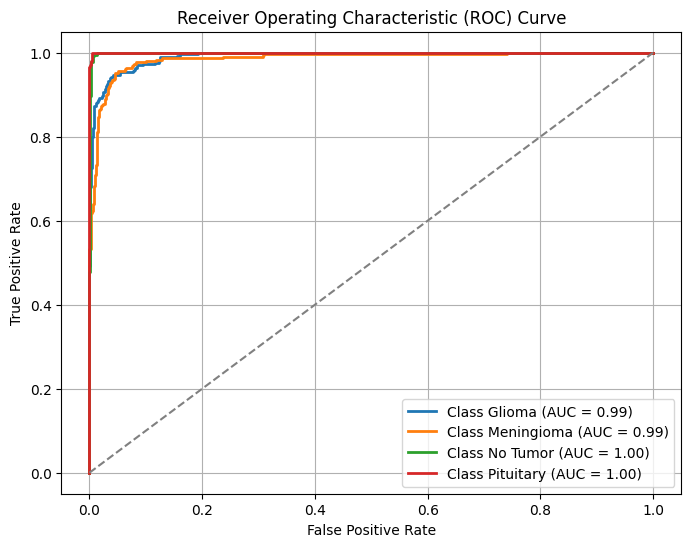

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# ✅ 1️⃣ Plot Training & Testing Accuracy per Epoch
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy", marker='o', linestyle='dashed')
plt.plot(test_accuracies, label="Test Accuracy", marker='o', linestyle='dashed')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Testing Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()

# ✅ 2️⃣ Plot Training & Testing Loss per Epoch
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", marker='o', linestyle='dashed')
plt.plot(test_losses, label="Test Loss", marker='o', linestyle='dashed')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Testing Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

# ✅ 3️⃣ Evaluate Model on Test Data
y_true, y_pred, y_prob = [], [], []
quantum_model.eval()

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = quantum_model(X_batch)
        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()  # Get probability scores
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = torch.argmax(y_batch, dim=1).cpu().numpy()
        
        y_pred.extend(preds)
        y_true.extend(labels)
        y_prob.extend(probs)

# ✅ 4️⃣ Generate Classification Report
report = classification_report(y_true, y_pred, target_names=["Glioma", "Meningioma", "No Tumor", "Pituitary"])
print("\n🔹 Classification Report:\n")
print(report)

# ✅ 5️⃣ Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# ✅ 6️⃣ Plot Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Glioma", "Meningioma", "No Tumor", "Pituitary"], 
            yticklabels=["Glioma", "Meningioma", "No Tumor", "Pituitary"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ 7️⃣ Convert Classification Report to DataFrame for Bar Chart
report_dict = classification_report(y_true, y_pred, target_names=["Glioma", "Meningioma", "No Tumor", "Pituitary"], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# ✅ 8️⃣ Plot Classification Report Metrics as Bar Chart
plt.figure(figsize=(8, 5))
report_df.iloc[:-1, :].plot(kind='bar', figsize=(10, 5), colormap="viridis")
plt.title("Classification Report Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ✅ 9️⃣ ROC Curve for Each Class
plt.figure(figsize=(8, 6))

for i in range(4):  # Since we have 4 classes
    fpr, tpr, _ = roc_curve(np.array(y_true) == i, np.array(y_prob)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color="grey", linestyle="--")  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
